In [1]:
%%capture
!pip install xbatcher tensorboard imbalanced-learn rioxarray

In [2]:
import os
if 'notebooks' in os.getcwd():
    os.chdir("..")

import util
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

# If we have gpu available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.set_default_device(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Prepare data

In [3]:
ds = xr.open_dataset("data_working/westmort.nc")\
    .squeeze(drop=True)\
    .drop_vars("spatial_ref")

In [4]:
# Use EWMA to smooth mortality observations
ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

ds["mort_ewma_diff"] = ds["mort_ewma"].diff(dim="time")

In [5]:
# Calculate total basal area based on all the genus rasters
ba_vars = ["abies", "picea", "populus", "tsuga", "pseudotsuga"]
ds["forest_ba"] = ds[ba_vars].to_stacked_array("band", sample_dims=["x", "y", "time"]).sum(dim="band")

In [6]:
ds = ds.to_stacked_array("band", sample_dims=["x", "y", "time"])\
    .transpose("time", "band", ...)
ds

<xarray.DataArray 'abies' (time: 27, band: 19, y: 652, x: 590)> Size: 789MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]], dtype=float32)
Coordinates:
  * time      (time) int64 216B 1997 1998 1999 2000 2001 ... 2020 2021 2022 2023
  * x         (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y         (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * band      (band) object 152B MultiIndex
  * variable  (band) <U14 1kB 'abies' 'picea' ... 'mort_ewma_diff' 'forest_ba'

Make sure windowing works right

In [7]:
target = "mort_ewma"
window_x_size = 8
window_y_size = 8
window_t_size = 3
window = dict(x=[window_x_size, False], y=[window_y_size, False], time=[window_t_size, False])
prop_na = 0.8
mort_arr = ds.sel(band=target, drop=True)
mort_ds = util.datasets.WindowXarrayDataset(ds, window, mask=mort_arr, na_thresh=prop_na)

print(len(mort_ds))

562805


In [8]:
eg_window = mort_ds[10]
window_x = eg_window.isel(time=slice(None, -1))
window_y = eg_window.isel(time=-1).sel(band=target)

In [9]:
assert (1 - np.mean(np.isnan(window_y.values))) > prop_na

Set up model definition

In [10]:
ds.band

<xarray.DataArray 'band' (band: 19)> Size: 152B
array([('abies',), ('picea',), ('populus',), ('pseudotsuga',), ('tsuga',),
       ('vod',), ('elev',), ('slope',), ('northness',), ('eastness',),
       ('fire',), ('mortality',), ('prcp',), ('vp',), ('tmin',),
       ('treecover',), ('mort_ewma',), ('mort_ewma_diff',), ('forest_ba',)],
      dtype=object)
Coordinates:
  * band      (band) object 152B MultiIndex
  * variable  (band) <U14 1kB 'abies' 'picea' ... 'mort_ewma_diff' 'forest_ba'

Data pipeline

In [11]:
# Prepare data laoders. Each dataset has to be temporally disjoint so we 
# don't leak data.
input_bands = ["mort_ewma", "prcp", "elev", "treecover"]
input_inds = np.where(np.isin(ds.coords.get("variable").values, input_bands))[0]
input_channel = len(input_bands)
years = ds.time.values

train_years = years[16:]
valid_years = years[:8]
test_years = years[8:16]

print("Training years:", train_years)
print("Validation years:", valid_years)
print("Testing years:", test_years)

Training years: [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]
Validation years: [1997 1998 1999 2000 2001 2002 2003 2004]
Testing years: [2005 2006 2007 2008 2009 2010 2011 2012]


In [12]:
valid_wds = util.datasets.WindowXarrayDataset(
    ds.sel(time=valid_years), window, 
    mask=mort_arr.sel(time=valid_years),
    na_thresh=prop_na
)
test_wds  = util.datasets.WindowXarrayDataset(
    ds.sel(time=test_years), window, 
    mask=mort_arr.sel(time=test_years), 
    na_thresh=prop_na
)

print("Count of examples")
print("Validation:", len(valid_wds))
print("Testing:", len(test_wds))

Count of examples
Validation: 99660
Testing: 167214


In [13]:
from torch.utils.data import DataLoader

ewma_target_ind = np.where(ds.coords.get("variable").values == target)[0][0]
orig_target_ind = np.where(ds.coords.get("variable").values == "mortality")[0][0]

dtype = torch.float32
eps = 1e-3

def make_collator(input_inds, target_ind):
    def collator(patch_list):
        X = torch.stack([
            torch.tensor(
                np.squeeze(patch.values[:-1, input_inds, :, :]),
                dtype=dtype
            )
            for patch in patch_list
        ])
    
        # Replace nan cells with the channel mean from this batch
        ch_mean = torch.nanmean(X, dim=0)
        X = torch.nan_to_num(X)
        X += ch_mean * torch.isnan(X)
        
        y = torch.stack([
            torch.tensor(patch.values[-1, target_ind, :, :], dtype=dtype)
            for patch in patch_list
        ]).squeeze(dim=2)/100
    
        return X, y

    return collator

ewma_collator = make_collator(input_inds, ewma_target_ind)
orig_collator = make_collator(input_inds, orig_target_ind)

batch_size = 128

# Setting the RNG to host device is necessary if we want to run on GPU
valid_loader = DataLoader(
    valid_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=ewma_collator, 
    generator=torch.Generator(device=device)
)
test_loader  = DataLoader(
    test_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=ewma_collator, 
    generator=torch.Generator(device=device)
)

In [14]:
reload(util.datasets)

<module 'util.datasets' from '/home/jovyan/ForestLST/util/datasets.py'>

In [15]:
import torchmetrics

wds = util.datasets.WindowXarrayDataset(
    ds.sel(time=train_years), window, mask=mort_arr.sel(time=train_years), na_thresh=prop_na
)
print(f"N: {len(wds)}")

train_loader = DataLoader(
    wds, batch_size, 
    shuffle=True, collate_fn=ewma_collator, 
    generator=torch.Generator(device=device)
)

N: 189448


In [16]:
reload(util.training)
from util.training import BaseTrainer, ReduceLRMixin, EarlyStopMixin, MaskedLossMixin

class Trainer(MaskedLossMixin, ReduceLRMixin, EarlyStopMixin, BaseTrainer):
    pass

In [17]:
from util.convlstm import ConvLSTM, DamageConvLSTM
from collections import OrderedDict

class PermuteLayer(torch.nn.Module):
    def __init__(self, dims: tuple[int, ...]) -> None:
        super().__init__()
        self.dims = dims

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.permute(*self.dims)

class LambdaLayer(torch.nn.Module):
    def __init__(self, f, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.f = f
    def forward(self, x):
        return self.f(x)

class MultiplyLayer(torch.nn.Module):
    def __init__(self, by, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.by = by

    def forward(self, x):
        return self.by * x

input_dim = len(input_bands)
hidden_dim = 8
num_layers = 3
kernel_size = (3, 3)
dropout = 0.3
dclstm = DamageConvLSTM(
    input_dim,
    hidden_dim,
    kernel_size,
    num_layers,
    dropout=dropout,
    batch_first=True
)

m = torch.nn.Sequential(OrderedDict([
    ("convlstm", dclstm),
    ("sigmoid", torch.nn.Sigmoid())
]))

print("N params:", util.training.count_trainable_parameters(m))

N params: 12849


In [18]:
# Check shapes
X, y = tuple(next(iter(valid_loader)))
print(X.shape)
out = m(X)
print(out.shape)
assert out.shape == y.shape

torch.Size([128, 2, 4, 8, 8])
torch.Size([128, 8, 8])


In [23]:
# Build trainer
loss = torch.nn.MSELoss()
opt  = torch.optim.Adam(m.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, factor=0.2, threshold=0.01)
metrics = util.training.get_regr_metrics()

model_name = f"03312025_convlstm__8_8_3__ewma__3x3conv"
logdir = os.path.join("logs", model_name)

# Remove existing logs if present
if os.path.exists(logdir):
    util.training.remove_log(logdir)

trainer = Trainer(
    m, opt, scheduler, loss, train_loader, valid_loader,
    metrics=metrics, 
    n_epochs=30,
    tensorboard_log=os.path.join(logdir, "history"),
    model_log=os.path.join(logdir, "model.pth"),
    defn_log=os.path.join(logdir, "model_definition.txt"),
    verbose=True,
    stop_patience=5,
    rel_improve=0.01,
)

trainer.train()

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training loss:   0%|          | 0/1481 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation loss:   0%|          | 0/779 [00:00<?, ?it/s]

Epoch 1 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.004273
2                               Loss/valid  tensor(0.0021)
3                MeanAbsoluteError()/train      0.02697447
4                MeanAbsoluteError()/valid     0.015191889
5                 MeanSquaredError()/train    0.0042733266
6                 MeanSquaredError()/valid    0.0021360186
7   NormalizedRootMeanSquaredError()/train       2.1031122
8   NormalizedRootMeanSquaredError()/valid        2.386106
9                  PearsonCorrCoef()/train       0.6121502
10                 PearsonCorrCoef()/valid       0.6256327



Training loss:   0%|          | 0/1481 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/779 [00:00<?, ?it/s]

Epoch 2 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.002241
2                               Loss/valid  tensor(0.0020)
3                MeanAbsoluteError()/train     0.020814218
4                MeanAbsoluteError()/valid     0.014526976
5                 MeanSquaredError()/train    0.0022409575
6                 MeanSquaredError()/valid    0.0020048413
7   NormalizedRootMeanSquaredError()/train        1.522988
8   NormalizedRootMeanSquaredError()/valid       2.3116775
9                  PearsonCorrCoef()/train      0.79663193
10                 PearsonCorrCoef()/valid      0.65501046



Training loss:   0%|          | 0/1481 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/779 [00:00<?, ?it/s]

Epoch 3 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train         0.00209
2                               Loss/valid  tensor(0.0020)
3                MeanAbsoluteError()/train     0.019833166
4                MeanAbsoluteError()/valid     0.014216978
5                 MeanSquaredError()/train    0.0020900636
6                 MeanSquaredError()/valid    0.0020152032
7   NormalizedRootMeanSquaredError()/train        1.470818
8   NormalizedRootMeanSquaredError()/valid       2.3176403
9                  PearsonCorrCoef()/train       0.8119272
10                 PearsonCorrCoef()/valid        0.655166



Training loss:   0%|          | 0/1481 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/779 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 4 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train           0.002
2                               Loss/valid  tensor(0.0021)
3                MeanAbsoluteError()/train     0.019364115
4                MeanAbsoluteError()/valid     0.013945156
5                 MeanSquaredError()/train    0.0020001803
6                 MeanSquaredError()/valid    0.0021099544
7   NormalizedRootMeanSquaredError()/train       1.4388438
8   NormalizedRootMeanSquaredError()/valid       2.3715026
9                  PearsonCorrCoef()/train       0.8207814
10                 PearsonCorrCoef()/valid       0.6449774



Training loss:   0%|          | 0/1481 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/779 [00:00<?, ?it/s]

Epoch 5 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.001939
2                               Loss/valid  tensor(0.0020)
3                MeanAbsoluteError()/train     0.019061929
4                MeanAbsoluteError()/valid    0.0144804455
5                 MeanSquaredError()/train    0.0019394499
6                 MeanSquaredError()/valid    0.0019652646
7   NormalizedRootMeanSquaredError()/train       1.4168332
8   NormalizedRootMeanSquaredError()/valid       2.2887447
9                  PearsonCorrCoef()/train       0.8266986
10                 PearsonCorrCoef()/valid       0.6607599



Training loss:   0%|          | 0/1481 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/779 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 6 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.001901
2                               Loss/valid  tensor(0.0020)
3                MeanAbsoluteError()/train     0.018914387
4                MeanAbsoluteError()/valid     0.014114012
5                 MeanSquaredError()/train     0.001901353
6                 MeanSquaredError()/valid    0.0019693996
7   NormalizedRootMeanSquaredError()/train       1.4028484
8   NormalizedRootMeanSquaredError()/valid       2.2911544
9                  PearsonCorrCoef()/train      0.83036584
10                 PearsonCorrCoef()/valid       0.6613105



Training loss:   0%|          | 0/1481 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/779 [00:00<?, ?it/s]

Epoch 7 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train         0.00187
2                               Loss/valid  tensor(0.0020)
3                MeanAbsoluteError()/train     0.018774576
4                MeanAbsoluteError()/valid     0.013970991
5                 MeanSquaredError()/train    0.0018694417
6                 MeanSquaredError()/valid    0.0019793687
7   NormalizedRootMeanSquaredError()/train       1.3910272
8   NormalizedRootMeanSquaredError()/valid       2.2969418
9                  PearsonCorrCoef()/train        0.833469
10                 PearsonCorrCoef()/valid       0.6633129



Training loss:   0%|          | 0/1481 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/779 [00:00<?, ?it/s]

Epoch 8 of 30
                                       Key           Value
0                             LearningRate           0.005
1                               Loss/train        0.001862
2                               Loss/valid  tensor(0.0020)
3                MeanAbsoluteError()/train      0.01874658
4                MeanAbsoluteError()/valid     0.015558574
5                 MeanSquaredError()/train    0.0018619604
6                 MeanSquaredError()/valid    0.0020400293
7   NormalizedRootMeanSquaredError()/train       1.3882399
8   NormalizedRootMeanSquaredError()/valid       2.3318722
9                  PearsonCorrCoef()/train      0.83419085
10                 PearsonCorrCoef()/valid       0.6448762



Training loss:   0%|          | 0/1481 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/779 [00:00<?, ?it/s]

Epoch 9 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001841
2                               Loss/valid  tensor(0.0020)
3                MeanAbsoluteError()/train     0.018647509
4                MeanAbsoluteError()/valid     0.014476488
5                 MeanSquaredError()/train    0.0018407166
6                 MeanSquaredError()/valid     0.002013047
7   NormalizedRootMeanSquaredError()/train       1.3802983
8   NormalizedRootMeanSquaredError()/valid       2.3164043
9                  PearsonCorrCoef()/train       0.8362553
10                 PearsonCorrCoef()/valid       0.6507449



Training loss:   0%|          | 0/1481 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/779 [00:00<?, ?it/s]

Epoch 10 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001794
2                               Loss/valid  tensor(0.0020)
3                MeanAbsoluteError()/train     0.018437466
4                MeanAbsoluteError()/valid     0.014227293
5                 MeanSquaredError()/train    0.0017933728
6                 MeanSquaredError()/valid    0.0020169662
7   NormalizedRootMeanSquaredError()/train       1.3624316
8   NormalizedRootMeanSquaredError()/valid        2.318657
9                  PearsonCorrCoef()/train       0.8408358
10                 PearsonCorrCoef()/valid       0.6505265



Training loss:   0%|          | 0/1481 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/779 [00:00<?, ?it/s]

Epoch 11 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001797
2                               Loss/valid  tensor(0.0020)
3                MeanAbsoluteError()/train     0.018413052
4                MeanAbsoluteError()/valid     0.014131736
5                 MeanSquaredError()/train    0.0017925077
6                 MeanSquaredError()/valid    0.0019821944
7   NormalizedRootMeanSquaredError()/train       1.3621037
8   NormalizedRootMeanSquaredError()/valid       2.2985847
9                  PearsonCorrCoef()/train       0.8409228
10                 PearsonCorrCoef()/valid      0.65812385



Training loss:   0%|          | 0/1481 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/779 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 12 of 30
                                       Key           Value
0                             LearningRate           0.001
1                               Loss/train        0.001786
2                               Loss/valid  tensor(0.0020)
3                MeanAbsoluteError()/train      0.01837171
4                MeanAbsoluteError()/valid     0.013993802
5                 MeanSquaredError()/train    0.0017826624
6                 MeanSquaredError()/valid     0.002045254
7   NormalizedRootMeanSquaredError()/train        1.358357
8   NormalizedRootMeanSquaredError()/valid       2.3348603
9                  PearsonCorrCoef()/train      0.84187394
10                 PearsonCorrCoef()/valid      0.65443903



(<Figure size 640x480 with 6 Axes>,
 <Axes: title={'center': 'MeanSquaredError()'}>)

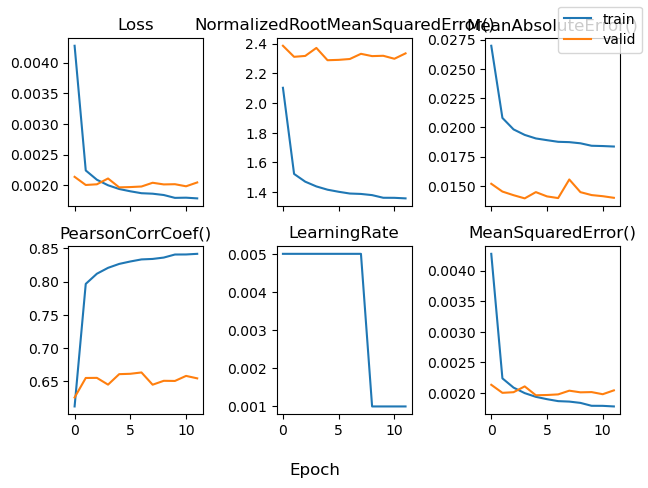

In [24]:
util.plot.plot_all_scalars_in_run(f"logs/{model_name}/history/")

Calculate performance on test set

In [25]:
from tqdm import tqdm
import pandas as pd

test_metrics = util.training.get_regr_metrics()

m.eval()
with torch.no_grad():
    for (X, y) in tqdm(test_loader, leave=False):
        y_hat = m(X)
        mask = ~torch.isnan(y)
        
        for metric in test_metrics:
            metric(y_hat[mask].view(-1), y[mask].view(-1))

for metric in test_metrics:
    print(f"{str(metric)}: {metric.compute():.3f}")

NormalizedRootMeanSquaredError(): 1.654
PearsonCorrCoef(): 0.843
MeanAbsoluteError(): 0.011
MeanSquaredError(): 0.001


In [26]:
train_metrics = util.training.get_final_metrics(f"logs/{model_name}/history")

In [27]:
train_metrics

{'NormalizedRootMeanSquaredError()/train': 1.3583569526672363,
 'PearsonCorrCoef()/train': 0.8418739438056946,
 'MeanAbsoluteError()/train': 0.018371710553765297,
 'MeanSquaredError()/train': 0.001782662351615727,
 'NormalizedRootMeanSquaredError()/valid': 2.334860324859619,
 'PearsonCorrCoef()/valid': 0.6544390320777893,
 'MeanAbsoluteError()/valid': 0.013993801549077034,
 'MeanSquaredError()/valid': 0.0020452539902180433,
 'Loss/train': 0.0017858367646113038,
 'Loss/valid': 0.0020453825127333403,
 'LearningRate': 0.0010000000474974513}

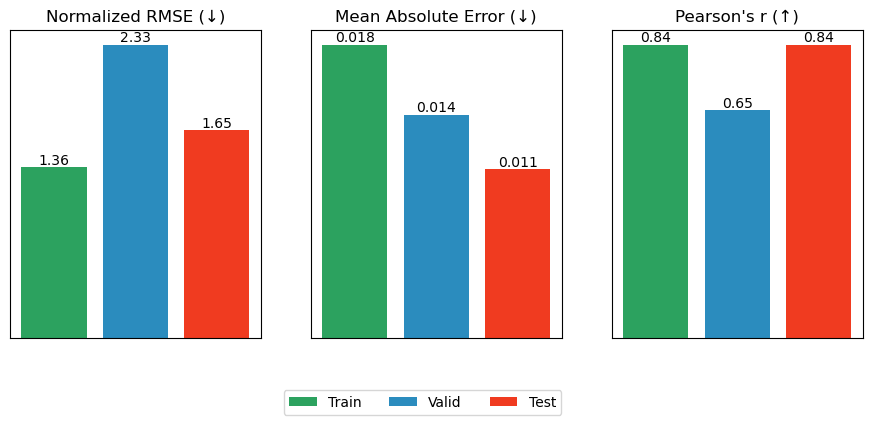

In [28]:
from matplotlib.patches import Rectangle

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 4))

nrmse = "NormalizedRootMeanSquaredError()"
mae = "MeanAbsoluteError()"
rho = "PearsonCorrCoef()"

label = ["Train", "Valid", "Test"]
color = ["#2ca25f", "#2b8cbe", "#f03b20"]

nrmse_values = [
    train_metrics[f"{nrmse}/train"],
    train_metrics[f"{nrmse}/valid"], 
    test_metrics[0].compute().cpu(), 
]
r2_values = [
    train_metrics[f"{rho}/train"], 
    train_metrics[f"{rho}/valid"], 
    test_metrics[1].compute().cpu(), 
]
mae_values = [
    train_metrics[f"{mae}/train"], 
    train_metrics[f"{mae}/valid"], 
    test_metrics[2].compute().cpu(), 
]
x = [0, 1, 2]

ax1.set_title("Normalized RMSE (↓)")
b = ax1.bar(x, nrmse_values, label=label, color=color)
ax1.bar_label(b, fmt="%.2f")
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

ax3.set_title("Pearson's r (↑)")
b = ax3.bar(x, r2_values, label=label, color=color)
ax3.bar_label(b, fmt="%.2f")
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
# ax2.legend()

ax2.set_title("Mean Absolute Error (↓)")
b = ax2.bar(x, mae_values, label=label, color=color)
ax2.bar_label(b, fmt="%.3f")
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
# ax2.legend()

handles, labels = ax1.get_legend_handles_labels()

plt.legend(handles, labels, ncol=3, loc = 'lower center', bbox_to_anchor = (0, -0.1, 1, 1),
           bbox_transform = plt.gcf().transFigure)
# fig.tight_layout()

Prediction map

In [29]:
ds_infer = ds.sel(time=np.concatenate([valid_years, test_years]))
wds_infer = util.datasets.WindowXarrayDataset(
    ds_infer, window, 
    mask=ds_infer.sel(band="mortality"), 
    na_thresh=0.5,
    downsample_step=10
)
print(len(wds_infer))

63583


In [30]:
ch_means = m.convlstm.bn.running_mean.unsqueeze(-1).unsqueeze(-1)

def inference_collator(patch):
    X = torch.tensor(
            np.squeeze(patch.values[:-1, input_inds, :, :]),
            dtype=dtype,
            device=device
        ).unsqueeze(0)

    # Replace nan cells with the channel mean
    X = torch.nan_to_num(X)
    X += ch_means * torch.isnan(X)
    return X

In [34]:
out_arr = np.zeros(ds_infer.isel(band=0).shape)
out_n   = np.zeros(out_arr.shape)

m.eval()
with torch.no_grad():
    for i in tqdm(range(len(wds_infer))):
        input_tensor = inference_collator(wds_infer[i])
        t = wds_infer.valid_indices["time"][i]
        y = wds_infer.valid_indices["y"][i]
        x = wds_infer.valid_indices["x"][i]
    
        output_tensor = m(input_tensor).detach().cpu().numpy()
    
        out_arr[t, y-window_y_size+1:y+1, x-window_x_size+1:x+1] += np.log10(output_tensor[0, ...])
        out_n[t, y-window_y_size+1:y+1, x-window_x_size+1:x+1] += 1

100%|██████████| 63583/63583 [02:53<00:00, 366.48it/s]


In [35]:
out_avg = out_arr / out_n
out_arr[out_n == 0] = np.nan
out_pct = 10 ** out_avg

out_da = xr.DataArray(
    data=out_pct,
    dims=["time", "y", "x"],
    coords=dict(
        time=ds_infer.time,
        y=ds_infer.y,
        x=ds_infer.x
    )
)

/tmp/ipykernel_567/2143291068.py:1: RuntimeWarning: invalid value encountered in divide
  out_avg = out_arr / out_n


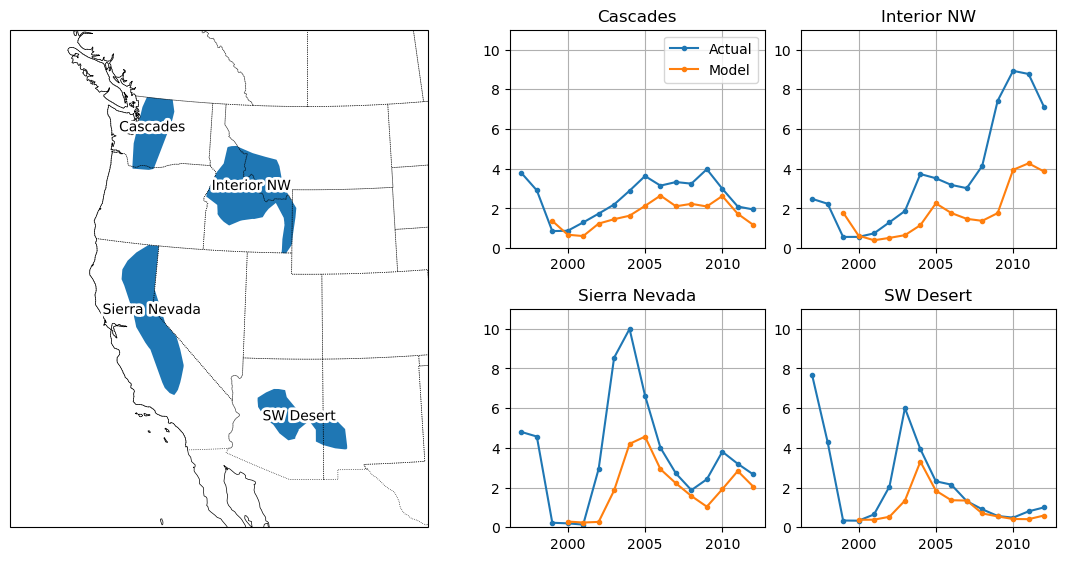

In [36]:
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as pe
import geopandas as gpd
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import shapely
from shapely.geometry import box

regions = gpd.read_file("data_in/regions_simple2.geojson")

fig = plt.Figure(layout="constrained", figsize=(11, 5.5))
gs = GridSpec(2, 3, figure=fig, width_ratios=[2, 1, 1])

projection = ccrs.AlbersEqualArea(central_latitude=42, central_longitude=-110)
map_ax = fig.add_subplot(gs[:, 0], projection=projection)

# Make the map
map_ax.coastlines(linewidth=0.5)

# Expand the bounding box a little so that we don't crop too much
mycrs = ccrs.epsg("3857")
bbox = box(*regions.total_bounds)
bbox = bbox.buffer(5e5) # meters

minx, miny, maxx, maxy = shapely.bounds(bbox)

# Add region geometries
for i in range(regions.shape[0]):
    geom = regions.geometry[i]
    map_ax.add_geometries(geom, crs=mycrs)
    map_ax.text(
        geom.centroid.x, geom.centroid.y, regions.name[i], 
        transform=mycrs,
        horizontalalignment="center",
        path_effects=[pe.withStroke(linewidth=4, foreground="white")]
    )

map_ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black', linewidth=0.5)
map_ax.set_extent((minx, maxx, miny, maxy), crs=mycrs)

axes = []

for i, (row, col) in enumerate(zip((1, 0, 1, 0), (2, 1, 1, 2))):
    ax = fig.add_subplot(gs[row, col])
    axes.append(ax)
    geom = regions.geometry[i]
    # Mean of geometric mean - no transformation necessary imo
    model = out_da.rio.write_crs(3857).rio.clip([geom]).mean(dim=["x", "y"], skipna=True).values * 100
    # Maybe do a geometric mean here?
    data  = ds_infer.sel(band="mort_ewma").rio.write_crs(3857).rio.clip([geom]).mean(dim=["x", "y"], skipna=True).values

    ax.plot(ds_infer.time, data, label="Actual", marker=".")
    ax.plot(ds_infer.time, model, label="Model", marker=".")
    ax.set_ylim(0, 11)
    ax.set_title(regions.name[i])
    ax.grid()

axes[1].legend()

fig